In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture


In [3]:
df = pd.read_csv(r"C:\Users\smith\Data_analysis\data\Dataset.csv")  
df.head()  
df.dtypes
df.info()
df.shape
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       20000 non-null  int64  
 1   avg_d_kbps       20000 non-null  int64  
 2   avg_u_kbps       20000 non-null  int64  
 3   avg_lat_ms       20000 non-null  int64  
 4   avg_lat_down_ms  19097 non-null  float64
 5   avg_lat_up_ms    19127 non-null  float64
 6   net_type         20000 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 1.1+ MB


,Unnamed: 0,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms
count,20000.000000,2.000000e+04,20000.000000,20000.000000,19097.000000,19127.000000
mean,10000.500000,1.095470e+05,37402.304000,34.833050,676.862177,931.673969
std,5773.647028,1.331239e+05,70862.574577,66.920457,832.009896,1144.083777
min,1.000000,4.000000e+00,1.000000,1.000000,2.000000,3.000000
25%,5000.750000,1.925750e+04,5331.000000,14.000000,207.000000,176.000000
50%,10000.500000,5.397650e+04,14261.000000,24.000000,432.000000,512.000000
75%,15000.250000,1.569445e+05,32455.000000,37.000000,802.000000,1253.000000
max,20000.000000,1.969184e+06,995535.000000,2722.000000,9538.000000,9718.000000


In [4]:
#drop duplicates and unused column
df = df.drop("Unnamed: 0", axis = 1)

In [5]:
df.head()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,net_type
0,9711,1489,21,208.0,NaN,moblie
1,50073,18199,40,475.0,1954.0,moblie
2,21784,745,47,1493.0,2252.0,moblie
3,18159,1662,21,244.0,2067.0,moblie
4,1439,659,749,2357.0,5083.0,moblie


In [6]:
# encode norminal data of the net_type column

#df["net_type"].unique()
df = pd.get_dummies(df, columns=["net_type"], dtype=int)
df = df.rename(columns={"net_type_moblie": "net_type_mobile"})
df

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,net_type_fixed,net_type_mobile
0,9711,1489,21,208.0,NaN,0,1
1,50073,18199,40,475.0,1954.0,0,1
2,21784,745,47,1493.0,2252.0,0,1
3,18159,1662,21,244.0,2067.0,0,1
4,1439,659,749,2357.0,5083.0,0,1
...,...,...,...,...,...,...,...
19995,215644,114035,14,384.0,606.0,1,0
19996,48533,17553,34,172.0,43.0,1,0
19997,5732,473,52,8039.0,304.0,1,0
19998,116025,129465,8,91.0,219.0,1,0


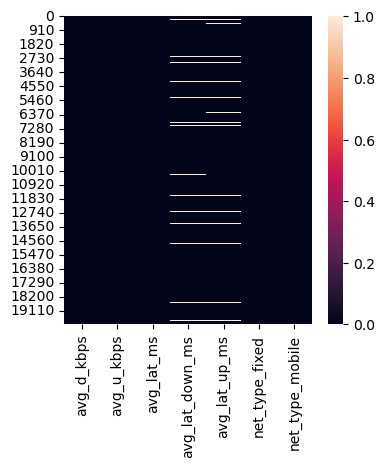

In [7]:
#show missing values and drop any duplicates 
df = df.drop_duplicates()
df.isnull().sum() # avg_lat_down_ms 903 missing , avg_lat_up_ms 873 missing
plt.figure(figsize=(4, 4))
sns.heatmap(df.isnull())
plt.show()

In [8]:
#impute the missing values using k nearest neighbors 

def impute_missing_values(df):
    
    imputer = KNNImputer(n_neighbors=5)  

    for column in df.columns:
        if df[column].isnull().sum() > 0:  
        
           df[column] = imputer.fit_transform(df[column].values.reshape(-1, 1))

    return df


In [9]:
impute_missing_values(df)
df.isnull().sum()

avg_d_kbps         0
avg_u_kbps         0
avg_lat_ms         0
avg_lat_down_ms    0
avg_lat_up_ms      0
net_type_fixed     0
net_type_mobile    0
dtype: int64

In [10]:
#feature engineering

#the ratio of download to upload speed as a new feature
df["speed_ratio"] = df["avg_d_kbps"] / df["avg_u_kbps"]
#the ratio of latency download to upload as new feature
df["latency_ratio"] = df["avg_lat_down_ms"] / (df["avg_lat_up_ms"])

#categorising the download speeds.
low_lim = df["avg_d_kbps"].quantile(0.33)  
high_lim = df["avg_d_kbps"].quantile(0.66)  

df

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,net_type_fixed,net_type_mobile,speed_ratio,latency_ratio
0,9711,1489,21,208.0,931.673969,0,1,6.521827,0.223254
1,50073,18199,40,475.0,1954.000000,0,1,2.751415,0.243091
2,21784,745,47,1493.0,2252.000000,0,1,29.240268,0.662966
3,18159,1662,21,244.0,2067.000000,0,1,10.925993,0.118045
4,1439,659,749,2357.0,5083.000000,0,1,2.183612,0.463703
...,...,...,...,...,...,...,...,...,...
19995,215644,114035,14,384.0,606.000000,1,0,1.891033,0.633663
19996,48533,17553,34,172.0,43.000000,1,0,2.764940,4.000000
19997,5732,473,52,8039.0,304.000000,1,0,12.118393,26.444079
19998,116025,129465,8,91.0,219.000000,1,0,0.896188,0.415525


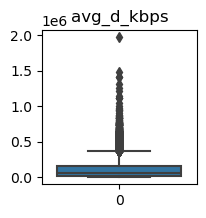

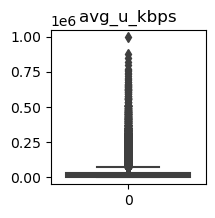

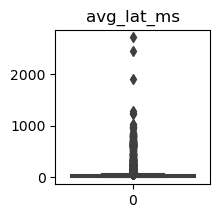

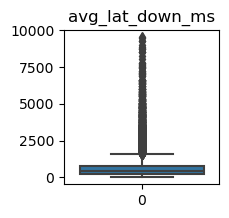

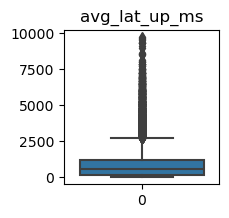

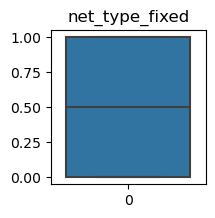

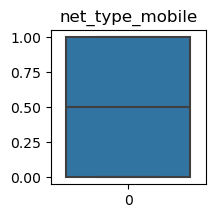

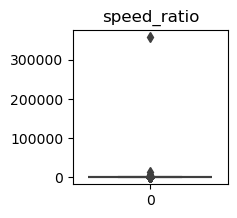

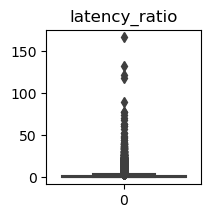

In [11]:
#plotting the distrubtion of each features a boxplot

features = df.columns.tolist()
for column in features:
    plt.figure(figsize=(2, 2))
    sns.boxplot(df[column])
    plt.title(column)
    plt.show()

In [12]:
#identify outliers: https://www.youtube.com/watch?v=ADY2co093vY

def iqr_outlier(df):
    features = df.columns.tolist()

    for column in features:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        iqr = q3 - q1 
        
        up_lim = q3 + (1.5*iqr)
        low_lim = q1 - (1.5*iqr)
        
        df[column] = np.where(df[column]>up_lim, up_lim,
                np.where(df[column]<low_lim, low_lim, df[column]))
    return df

In [13]:
df.describe()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,net_type_fixed,net_type_mobile,speed_ratio,latency_ratio
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.095470e+05,37402.304000,34.833050,676.862177,931.673969,0.500000,0.500000,29.034878,1.866344
std,1.331239e+05,70862.574577,66.920457,813.009377,1118.834276,0.500013,0.500013,2533.430251,4.102619
min,4.000000e+00,1.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.003916,0.001395
25%,1.925750e+04,5331.000000,14.000000,216.000000,186.000000,0.000000,0.000000,1.620839,0.450438
50%,5.397650e+04,14261.000000,24.000000,460.000000,557.000000,0.500000,0.500000,3.664299,0.820014
75%,1.569445e+05,32455.000000,37.000000,774.000000,1203.000000,1.000000,1.000000,8.409554,1.753017
max,1.969184e+06,995535.000000,2722.000000,9538.000000,9718.000000,1.000000,1.000000,357814.000000,166.794872


In [14]:
df = iqr_outlier(df)

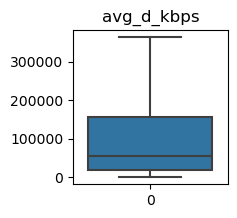

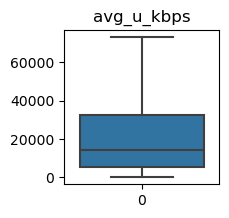

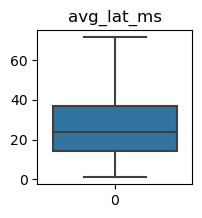

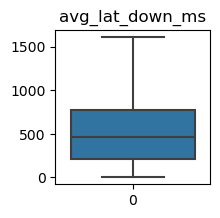

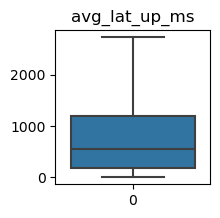

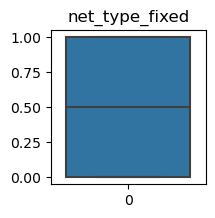

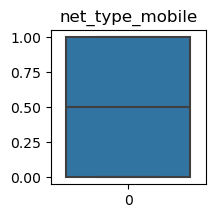

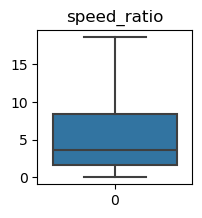

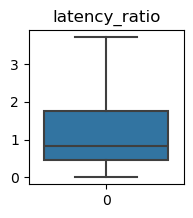

In [15]:
#showing distrubtion of each feature after hadnling outliers

features = df.columns.tolist()
for column in features:
    if column == "Download_performance":
        break
    plt.figure(figsize=(2, 2))
    sns.boxplot(df[column])
    plt.title(column)
    plt.show()

In [16]:
#save the data cleaning steps to be used at the next step
df.to_csv(r"C:\Users\smith\Data_analysis\data\Data2.csv")